In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import pdist 

from lenskit.datasets import ML100K, MovieLens
from lenskit.algorithms import Recommender, als

import trecs
from trecs.models import ImplicitMF, ImplicitMFLFD, ContentFiltering
from trecs.random import Generator
from trecs.metrics import MSEMeasurement, AverageFeatureScoreRange, RecSimilarity, InteractionSimilarity


In [2]:
GENERATOR = np.random.default_rng(1234)

In [3]:
# basically just recommends items based on the estimates of user preferences!
# this will form the basis of our "ideal" recommender
class IdealRecommender(ContentFiltering):
    def _update_internal_state(self, interactions):
        # do not change users_hat! 
        pass
    
    def process_new_items(self, new_items):
        """
        Generate zero attributes for new items. Remember,
        this doesn't actually matter because the IdealRecommender
        uses its perfect score function, not
        """
        num_items = new_items.shape[1]
        num_attr = self.items_hat.shape[0]
        item_representation = GENERATOR.random((num_attr, num_items))
        return item_representation

# random recommender - randomly update users at every step
class RandomRecommender(ContentFiltering):
    def _update_internal_state(self, interactions):
        self.items_hat[:, :] = GENERATOR.random(self.items_hat.shape)
        self.users_hat[:, :] = GENERATOR.random(self.users_hat.shape)
        
    def process_new_items(self, new_items):
        """
        Generate random attributes for new items.
        """
        num_items = new_items.shape[1]
        num_attr = self.items_hat.shape[0]
        item_representation = GENERATOR.random((num_attr, num_items))
        return item_representation

In [4]:
model_params = {'iterations': 100}
# NUM_USERS = 500
# NUM_ITEMS= 1000
# N_FACTORS = 15

NUM_USERS = 100
NUM_ITEMS = 10000
N_FACTORS = 10
NUM_STEPS = 100
js_pairs = [(u1_idx, u2_idx) for u1_idx in range(NUM_USERS) for u2_idx in range(NUM_USERS) if u1_idx != u2_idx] 



In [17]:
# user_representation = Generator().binomial(
#     n=1, p=.3, size=(NUM_USERS, N_FACTORS)
# )

# item_representation = Generator().binomial(
#     n=1, p=.3, size=(N_FACTORS, NUM_ITEMS)
# )
# # Initialize with custom representations
# filtering = ContentFiltering(user_representation=user_representation,
#                             item_representation=item_representation)

# filtering.add_metrics(AverageFeatureScoreRange())
# filtering.run(10)

# filtering.get_measurements()


In [18]:
# filtering.items_hat.all() in [0,1]

In [5]:
mf = ImplicitMF(num_users=NUM_USERS, num_items=NUM_ITEMS, num_latent_factors=N_FACTORS, num_items_per_iter=10)
                #model_params=model_params)
mf.add_metrics(MSEMeasurement())
mf.add_metrics(AverageFeatureScoreRange())
#mf.add_metrics(RecSimilarity(pairs=js_pairs))
mf.add_metrics(InteractionSimilarity(pairs=js_pairs))
mf.startup_and_train(20)
mf.run(timesteps=NUM_STEPS, train_between_steps=True, reset_interactions=False)
#mf.run(timesteps=NUM_STEPS)

100%|██████████| 20/20 [00:01<00:00, 14.19it/s]
/Users/amywinecoff/Documents/CITP/Research/Github/t-recs/trecs/models/mf.py:262: UserWarning: train_between_steps is set to True. Note that, at each step, this overwrites the MF model with a model fit only to the latest interaction. To avoid this behavior, set train_between_steps to False.
  "train_between_steps is set to True. Note that, at each step, this "
100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


In [6]:
mflfd = ImplicitMFLFD(num_users=NUM_USERS, num_items=NUM_ITEMS, num_latent_factors=N_FACTORS, num_items_per_iter=10,
                     top_n_limit=50) 
                     # model_params=model_params)
mflfd.add_metrics(MSEMeasurement())
mflfd.add_metrics(AverageFeatureScoreRange())
#mflfd.add_metrics(RecSimilarity(pairs=js_pairs))
mflfd.add_metrics(InteractionSimilarity(pairs=js_pairs))
mflfd.startup_and_train(20)
mflfd.run(timesteps=NUM_STEPS, train_between_steps=True, reset_interactions=False)
#mflfd.run(timesteps=NUM_STEPS)

100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


In [7]:
mflfd_metrics = pd.DataFrame(mflfd.get_measurements())
mf_metrics = pd.DataFrame(mf.get_measurements())

In [35]:
mf.actual_user_item_scores

{'mse': [None,
  1.949108171590618,
  1.949108171590618,
  1.949108171590618,
  1.949108171590618,
  1.949108171590618,
  1.949108171590618,
  1.949108171590618,
  1.949108171590618,
  1.949108171590618,
  1.949108171590618,
  1.949108171590618,
  1.949108171590618,
  1.949108171590618,
  1.949108171590618,
  1.949108171590618,
  1.949108171590618,
  1.949108171590618,
  1.949108171590618,
  1.949108171590618,
  1.949108171590618,
  1.786814239422395,
  1.7449562386421542,
  1.709922328153014,
  1.6426234566320708,
  1.6438957219450323,
  1.6158658261904197,
  1.6166047240459966,
  1.6046262200380073,
  1.5980663445433128,
  1.609332994039964,
  1.5589675415935937,
  1.5385599072397917,
  1.5237710993396383,
  1.553270870823523,
  1.5135434591901826,
  1.4902999902296068,
  1.4695011791172776,
  1.4829971026008941,
  1.471502322100946,
  1.4666668678563224,
  1.4247833482751737,
  1.439292688482119,
  1.4460652321256677,
  1.4473607645369289,
  1.4595199628454167,
  1.4114187231711417,

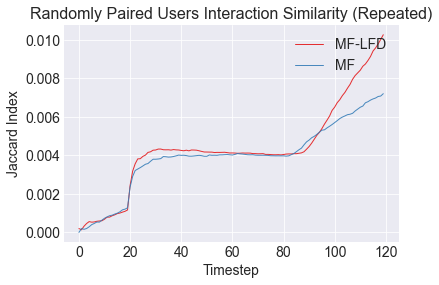

In [9]:
#mflfd_metrics = pd.DataFrame(mflfd.get_measurements())
mflfd_sim= mflfd_metrics['interaction_similarity'].to_list()[1:]

#mf_metrics = pd.DataFrame(mf.get_measurements())
mf_sim= mf_metrics['interaction_similarity'].to_list()[1:]
# style
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 14})

# create a color palette
palette = plt.get_cmap('Set1')

plt.plot(list(range(len(mflfd_sim))), mflfd_sim, marker='', color=palette(0), linewidth=1, alpha=0.9, label='MF-LFD')
plt.plot(list(range(len(mf_sim))), mf_sim, marker='', color=palette(1), linewidth=1, alpha=0.9, label='MF')

# Add legend
#plt.legend(loc=2, ncol=2)
plt.legend(loc=1, ncol=1)

# Add titles
plt.title("Randomly Paired Users Interaction Similarity (Repeated)", loc='center', fontsize=16, fontweight=2)
plt.xlabel("Timestep")
plt.ylabel("Jaccard Index")
plt.show()


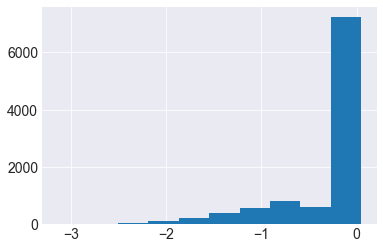

In [33]:
mf_mean = np.mean(mf.predicted_scores.value, axis=0)
plt.hist(mf_mean)
plt.show()

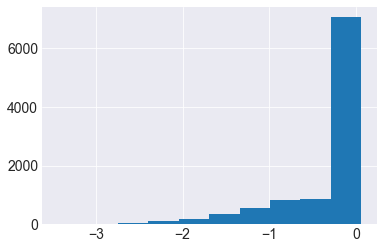

In [32]:
lfd_mean = np.mean(mflfd.predicted_scores.value, axis=0)
plt.hist(lfd_mean)
plt.show()

In [87]:
mf_scores = pd.DataFrame(mf.predicted_scores.value)
cols = [f"item_{c}" for c in mf_scores.columns]
mf_scores.columns = cols
#mf_scores.head()
mf_scores["user"] = list(range(mf_scores.shape[0]))

#list(range(mf_scores.shape[0]))

t=pd.wide_to_long(mf_scores, "item_", i="user", j="item").reset_index()
t.columns = ["user", "item", "predicted_score"]

Text(0, 0.5, 'Actual Scores')

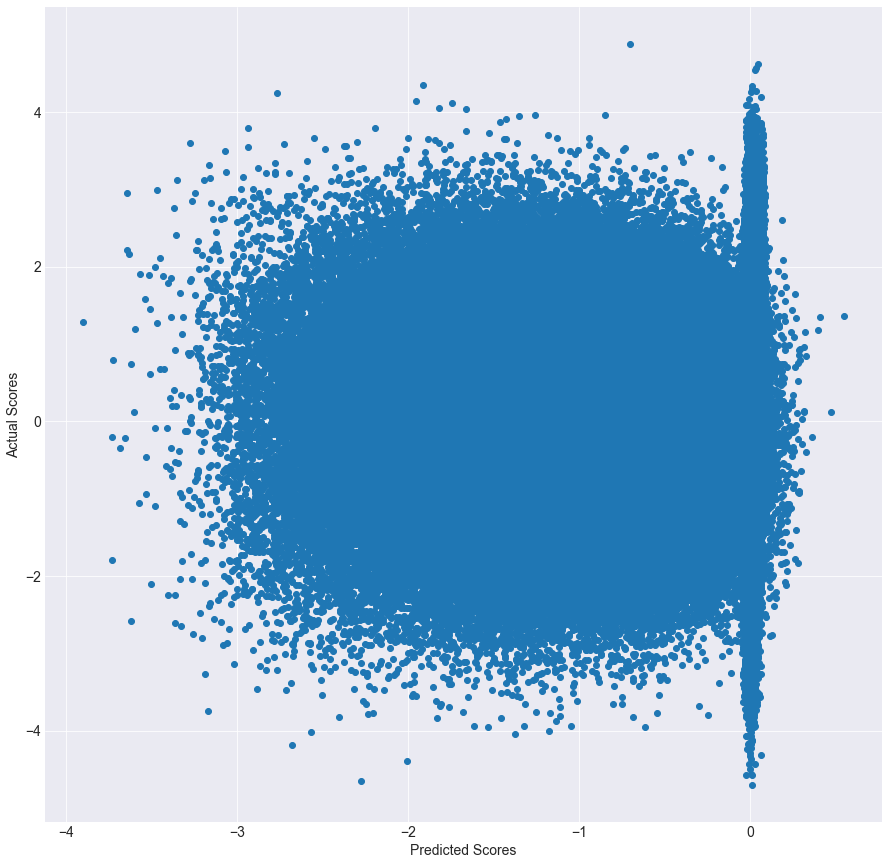

In [70]:
plt.figure(figsize=(15, 15))
plt.scatter(np.array(mf.predicted_scores.value).flatten(), mf.actual_user_item_scores.flatten())
plt.xlabel("Predicted Scores")
plt.ylabel("Actual Scores")

In [61]:
#plt.scatter(mf.actual_user_item_scores, mf.predicted_scores)
# from matplotlib.image import NonUniformImage
# print(mf.predicted_scores.value.shape)
# print(mf.actual_user_item_scores.shape)
H, xedges, yedges = np.histogram2d(np.array(mf.predicted_scores.value).flatten(), mf.actual_user_item_scores.flatten())
# H = H.T 

# fig = plt.figure(figsize=(7, 3))
# ax = fig.add_subplot(133, title='NonUniformImage: interpolated',aspect='equal')

# im = NonUniformImage(ax, interpolation='bilinear')

# xcenters = (xedges[:-1] + xedges[1:]) / 2
# ycenters = (yedges[:-1] + yedges[1:]) / 2
# im.set_data(xcenters, ycenters, H)
# ax.images.append(im)

# # plt.show()

(100, 10000)
(100, 10000)


TypeError: cannot unpack non-iterable NoneType object

<Figure size 504x216 with 1 Axes>

In [63]:
ycenters

array([-4.22622155, -3.26775824, -2.30929493, -1.35083162, -0.39236831,
        0.566095  ,  1.52455831,  2.48302162,  3.44148493,  4.39994824])

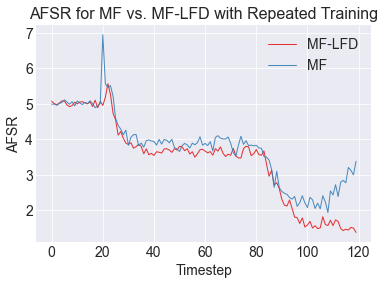

In [83]:
mf_afsr= mf_metrics['afsr'].to_list()[1:]
mflfd_afsr= mflfd_metrics['afsr'].to_list()[1:]

# style
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 14})

# create a color palette
palette = plt.get_cmap('Set1')

plt.plot(list(range(len(mflfd_afsr))), mflfd_afsr, marker='', color=palette(0), linewidth=1, alpha=0.9, label='MF-LFD')
plt.plot(list(range(len(mf_afsr))), mf_afsr, marker='', color=palette(1), linewidth=1, alpha=0.9, label='MF')

# Add legend
#plt.legend(loc=2, ncol=2)
plt.legend(loc=1, ncol=1)

# Add titles
plt.title("AFSR for MF vs. MF-LFD with Repeated Training", loc='center', fontsize=16, fontweight=2)
plt.xlabel("Timestep")
plt.ylabel("AFSR")
plt.show()



In [ ]:
mlsmall = MovieLens('../../t-recs-experiments/data/ml-latest-small')
ratings = mlsmall.ratings[['user', 'item']]

als = als.ImplicitMF(10, iterations=100)
als.fit(ratings)



In [ ]:
als_item_features = pd.DataFrame(als.item_features_)
mflfd_item_features = pd.DataFrame(mflfd.items_hat.T)
#mflfd_item_features.head()

mf_item_features = pd.DataFrame(mf.items_hat.T)
#mf_item_features.head()

In [ ]:
def plot_hist_features(features_df, model_type, color='blue'):
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 12}

    plt.rc('font', **font)

    n_features = list(range(0,10))
    fig, axs = plt.subplots(math.ceil(len(n_features)/3), 3, figsize=(20,20))
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                        wspace=0.35)
    fig.suptitle('Latent Factors for {}'.format(model_type), size=20)

    for idx, n_feature in enumerate(n_features):
        r=idx //3
        c=idx % 3

        #hat = features_df[n_feature].tolist()
        features = features_df[n_feature].tolist()
        axs[r, c].set_title('Factor {}'.format(n_feature))

        #axs[r,c].plot(hat, actual, 'o', color=color);
        axs[r,c].hist(features, color=color)

    #for ax in axs.flat:
    #    ax.set(xlabel='hat representation', ylabel='actual representation')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axs.flat:
    #    ax.label_outer()

    fig.delaxes(axs[3][1])
    fig.delaxes(axs[3][2])

In [ ]:
plot_hist_features(als_item_features, 'MovieLens MF')

In [ ]:
plot_hist_features(mflfd_item_features, 'MF-LFD', 'red')

In [ ]:
plot_hist_features(mf_item_features, 'MF', 'green')

In [103]:
mflfd_d = np.triu(pairwise_distances(mflfd.items_hat.value.T, metric="cosine"))

#mflfd_d[mflfd_d ==0] = np.nan
#arr[arr == 0] = 'nan' # or use np.nan
#mf_d = pairwise_distances(mflfd.items_hat, metric='correlation', force_all_finite="allow_nan")
#ml_d = pairwise_distances(als.item_features_.T, metric='correlation', force_all_finite="allow_nan")

mflfd_d.shape

(10000, 10000)

In [104]:
np.nanmean(mflfd_d)

#Y = pdist(mflfd.items_hat, 'cosine')

0.4961909496198552

In [105]:
np.max(mflfd_d)

1.982689616969998

In [ ]:
mflfd

In [ ]:
upper = np.triu(mflfd_d)

In [ ]:
recommended_item_attr.shape

In [ ]:
recommended_item_attr = mflfd.items_hat[:, mflfd.rec]
mflfd_d = pairwise_distances(recommended_item_attr, metric="euclidean")
mflfd_d.shape

In [55]:
# row = np.repeat(self.users.user_vector, item_indices.shape[1])
# row = row.reshape((self.num_users, -1))
# s_filtered = self.predicted_scores.value[row, item_indices]
# rec_scores = mflfd.predicted_scores.value[:, mflfd.rec]
# rec_scores

#top_k_att = self.items_hat.value[:, top_k_recs[:]]
rec_array = np.array(mflfd.rec)
rec_scores = mflfd.predicted_scores.value[:, rec_array]


In [56]:
print(mflfd.predicted_scores.value.shape)
print(rec_array.shape)
print(rec_scores.shape)

(100, 1000)
(100, 10)
(100, 100, 10)


In [51]:
rec_scores[0,0,:]

array([0.14877549, 0.05915087, 0.09695111, 0.12161561, 0.08125331,
       0.07229022, 0.11856703, 0.1181889 , 0.08125331, 0.12779414])

In [52]:
rec_array[0]

array([317, 540, 920, 340, 616, 382, 228,  20, 616, 773])

In [57]:
mflfd.predicted_scores.value[0,317]

0.1487754933122429

In [107]:
row=np.repeat(100, rec_array.shape[0])
#row = row.reshape((mflfd.num_users, -1))
row

array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100])

In [ ]:
x[:,np.arange(idx.shape[0])[:,None],idx]

mflfd.predicted_scores.value[:]

In [ ]:
class MeanRecDistance(Measurement):
    """
    Measures the average range (across users) of item attributes for items
    users were recommended at a time step.

    TODO Description

    This class inherits from :class:`.Measurement`.

    Parameters
    -----------

        verbose: bool (optional, default: False)
            If True, enables verbose mode. Disabled by default.

    Attributes
    -----------
        Inherited by Measurement: :class:`.Measurement`

        name: str (optional, default: "afsr")
            Name of the measurement component.
    """

    def __init__(self, name="mean_rec_distance", verbose=False):
        Measurement.__init__(self, name, verbose, init_value=None)

    def measure(self, recommender, **kwargs):
        """
        Measures the mean of the distance between all pairwise distances between recommendations

        Parameters
        ------------
            recommender: :class:`~models.recommender.BaseRecommender`
                Model that inherits from
                :class:`~models.recommender.BaseRecommender`.

            **kwargs
                Keyword arguments, one of which must be `items_shown`, a |U| x
                num_items_per_iter matrix that contains the indices of every
                item shown to every user at a particular timestep.
        """
        items_shown = kwargs.pop("items_shown", None)
        #print("interactions {}".format(interactions))

        #assert interactions.size == recommender.num_users
        recommended_item_attr = recommender.items_hat[:, items_shown]
        #print("interacted_item_att shape {}".format(interacted_item_attr.shape))

        if {item for item in recommended_item_attr.flatten()} == {0, 1}:
            raise ValueError("Mean recommendation distance is not intended for binary features.")

        afsr = np.mean(recommended_item_attr.max(axis=(0, 2)) - recommended_item_attr.min(axis=(0, 2)))

        self.observe(afsr)
